## Operations benchmarked
The aim of this notebook is to benchmark the fundamental linear algebra operation in the two frameworks. The operations that will be compared are the followings:
1. definition of variables
1. create a vector
1. activation function
1. dot product
1. matrix multiplication
1. flatten a vector
1. normalize a vector

## Workflow - General steps
For each of them we will follow these steps:
- define 2 benchmark functions (one for each framework) that contains a reasonable amount of computation
- set the necessary random seeds (framework, python, numpy)
- run the benchmark function multiple times (e.g. 100 times)
- record the time for each run 
- plot the two runs on a diagram
- run an HP to understand if the two distributions are significantly different
- take the conclusion: which is better and why?

## Benchmark Detail: Timing Function 
To benchmark the execution time of python function we used the library function process_time() before and after the function execution.

#### time.process_time() → float
Return the value (in fractional seconds) of the sum of the system and user CPU time of the current process. It does not include time elapsed during sleep. It is process-wide by definition. The reference point of the returned value is undefined, so that only the difference between the results of consecutive calls is valid.

*New in version 3.3.*

In [25]:
import time

start = time.process_time()
# your function here
end = time.process_time()
print("This is the general error magnitude: ", end - start)

This is the general error magnitude:  2.6577000028282782e-05


### Benchmark: Other CPU and RAM usages
source: https://stackoverflow.com/questions/276052/how-to-get-current-cpu-and-ram-usage-in-python

UPDATE: Here is some example usages of psutil:

In [26]:
#!/usr/bin/env python
import psutil
# gives a single float value
psutil.cpu_percent()
# gives an object with many fields
psutil.virtual_memory()
# you can convert that object to a dictionary 
dict(psutil.virtual_memory()._asdict())

{'total': 11534348288,
 'available': 6228094976,
 'percent': 46.0,
 'used': 4940627968,
 'free': 5615394816,
 'active': 5005451264,
 'inactive': 716341248,
 'buffers': 71888896,
 'cached': 906436608,
 'shared': 93241344,
 'slab': 95928320}

## Import the two frameworks

In [27]:
import mxnet as mx
import tensorflow as tf

print("Tensorflow version (by Google): ", tf.__version__)
print("MXnet version (by Amazon): ", mx.__version__)

Tensorflow version (by Google):  2.0.0
MXnet version (by Amazon):  1.5.1


In [28]:
import numpy as np
from typing import List, Tuple, Callable, Mapping
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
import pandas as pd
import seaborn as sns

def plot_timing(mx_list, tf_list):
    mx_s = pd.Series(mx_list)
    tf_s = pd.Series(tf_list)

    df = pd.concat([mx_s, tf_s], axis=1)
    df = df.rename(columns = {0:"mxnet", 1:"tensorflow"})
    return df.plot()

In [30]:
def plot_time_vs_seed_line_errorbar(df_result):
    # df_result should have 3 columns at least
    # two columns for the timing of the two frameworks
    # one last to record the seed, so to understand 
    # which timings (i.e. rows) are referred to the same exact
    # bag of vectors (that should represent the difficulty of the experiment)
    
    df_averaged = df_result.groupby('seed').mean()
    df_max = df_result.groupby('seed').max()
    df_min = df_result.groupby('seed').min()
    df_positive_error = df_max - df_averaged
    df_negative_error = df_averaged - df_min
    
    fig = plt.figure()
    fig.set_size_inches(18.5, 9)
    plt.errorbar(df_averaged.index, df_averaged["mxnet"], yerr=[df_negative_error["mxnet"], df_positive_error["mxnet"]])
    plt.errorbar(df_averaged.index, df_averaged["tensorflow"], yerr=[df_negative_error["tensorflow"], df_positive_error["tensorflow"]])
    plt.show()
    #df_averaged[["mxnet","tensorflow"]].plot()
def plot_time_vs_dimension_line_errorbar(df_result):
    # df_result should have 3 columns at least
    # two columns for the timing of the two frameworks
    # one last to record the seed, so to understand 
    # which timings (i.e. rows) are referred to the same exact
    # bag of vectors (that should represent the difficulty of the experiment)
    
    df_averaged = df_result.groupby('dim').mean()
    df_max = df_result.groupby('dim').max()
    df_min = df_result.groupby('dim').min()
    df_positive_error = df_max - df_averaged
    df_negative_error = df_averaged - df_min
    
    fig = plt.figure()
    fig.set_size_inches(18.5, 9)
    plt.errorbar(df_averaged.index, df_averaged["mxnet"], yerr=[df_negative_error["mxnet"], df_positive_error["mxnet"]])
    plt.errorbar(df_averaged.index, df_averaged["tensorflow"], yerr=[df_negative_error["tensorflow"], df_positive_error["tensorflow"]])
    plt.show()
    #df_averaged[["mxnet","tensorflow"]].plot()

In [31]:
def plot_time_vs_seed_boxplot(df_result):
    fig, ax = plt.subplots(figsize=(18.5, 9))
    
    sns.boxplot(df_result["seed"], df_result["mxnet"], ax=ax, color="C0")
    sns.boxplot(df_result["seed"], df_result["tensorflow"], ax=ax, color="C1")
    #https://stackoverflow.com/questions/53142308/how-to-change-the-colour-of-the-seaborn-boxplot-extensive-line-and-outliers
    ax.set_ylabel("time in fraction of seconds")

In [32]:
def plot_time_vs_dimension_boxplot(df_result):
    fig, ax = plt.subplots(figsize=(18.5, 9))
    
    sns.boxplot(df_result["dim"], df_result["mxnet"], ax=ax, color="C0")
    sns.boxplot(df_result["dim"], df_result["tensorflow"], ax=ax, color="C1")
    #https://stackoverflow.com/questions/53142308/how-to-change-the-colour-of-the-seaborn-boxplot-extensive-line-and-outliers
    ax.set_ylabel("time in fraction of seconds")
    ax.set_xlabel("vector dimension")

In [33]:
# test if the two samples are significantly different
# https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/
from scipy.stats import ttest_ind

def test_independence(mx_list, tf_list):
    stat, p = ttest_ind(mx_list, tf_list)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably the same distribution')
    else:
        print('Probably different distributions')

In [34]:
def generate_Vectors(seed : int, dimensions : int, nr_vectors : int, numpy : bool = True): 
    # set the seed
    np.random.seed(seed)
    # generate a set of vectors in numpy of the same dimensions
    bag_of_vectors : List[np.ndarray] = []
    for _ in range(nr_vectors):
        if numpy == True:
            bag_of_vectors += [np.random.rand(1, dimensions)]
        else:
            bag_of_vectors += [list(np.random.rand(1, dimensions))]
    #print(bag_of_vectors)
    return bag_of_vectors

In [35]:
def generate_Matrices(seed : int, dim_vertical : int, dim_horizontal : int, nr_matrices : int, numpy : bool = True): 
    # set the seed
    np.random.seed(seed)
    # generate a set of vectors in numpy of the same dimensions
    bag_of_matrices : List[np.ndarray] = []
    for _ in range(nr_matrices):
        if numpy == True:
            bag_of_matrices += [np.random.rand(dim_vertical,dim_horizontal)]
        else:
            bag_of_matrices += [list(np.random.rand(dim_vertical, dim_horizontal))]
    return bag_of_matrices

# 1. Definition of a Variable
Task to Benchmark: Creation of a huge number of variables (e.g. 1000, 10000, etc...)

Common to both frameworks: the data type, dimensions and name of the variables

In [36]:
# MXnet
'''
The Symbol API in Apache MXNet is an interface for symbolic programming. It features the use 
of computational graphs, reduced memory usage, and pre-use function optimization.

mxnet.symbol.Variable
(name, attr=None, shape=None, lr_mult=None, wd_mult=None, dtype=None, init=None, stype=None, **kwargs)
'''
# Tensorflow
'''
A TensorFlow variable is the best way to represent shared, persistent state manipulated by your program.
Variables are manipulated via the tf.Variable class. A tf.Variable represents a tensor whose value can 
be changed by running ops on it. Specific ops allow you to read and modify the values of this tensor. 
Higher level libraries like tf.keras use tf.Variable to store model parameters. This guide covers how 
to create, update, and manage tf.Variables in TensorFlow.

tf.Variable(
    initial_value=None, <-- not a fair comparison if we initialize also the tensor
    trainable=None,
    validate_shape=True,
    caching_device=None,
    name=None,
    variable_def=None,
    dtype=None,
    import_scope=None,
    constraint=None,
    synchronization=tf.VariableSynchronization.AUTO,
    aggregation=tf.compat.v1.VariableAggregation.NONE,
    shape=None
)
Placeholders are more similar to symbols in MXnet because they do not require an initial value
dtype: The type of elements in the tensor to be fed.
shape: The shape of the tensor to be fed (optional). If the shape is not specified, 
you can feed a tensor of any shape.
name: A name for the operation (optional).
tf.compat.v1.placeholder(
    dtype,
    shape=None,
    name=None
)
'''
# Create a variable/symbol without values
name_of_variable = "weights"
w_mx = mx.symbol.Variable(name_of_variable, shape=(1024, 1024), dtype = np.float32)
print(w_mx)
'''
# disable eager execution to use placeholders
tf.compat.v1.disable_eager_execution()

w_tf = tf.compat.v1.placeholder(tf.float32, name = name_of_variable,  shape=(1024, 1024))
print(w_tf)

# reenable eager execution
tf.compat.v1.enable_eager_execution()
'''
# there is no point of comparing mxnet with older functions of tf1 that are deprecated in tf2
print("No benchmark for variable definition")

<Symbol weights>
No benchmark for variable definition


# 2. Vector Creation
Task to Benchmark: Create a huge amount of vectors with the two proprietary library functions of the two frameworks

Common to both frameworks: The vectors created (ones, zeros, specific numbers) should be given as numpy array input to both frameworks.

In [37]:
# define the two benchmarking functions
def mx_vector_creation(params_dict, params_mx = None):
    # retrieve parameters
    bag_of_vectors = params_dict["vectors"]
    try:
        numpy = (params_mx["numpy_vectors"] == "y")
    except KeyError as e:
        numpy = False
    # start experiment
    mx_bag_of_vectors : List[mxnet.ndarray] = []
    for np_vector in bag_of_vectors:
        #print("Numpy in creation->  ", numpy)
        if numpy:
            mx_bag_of_vectors += [mx.ndarray.from_numpy(np_vector)]
        else:
            mx_bag_of_vectors += [mx.nd.array(np_vector, dtype='float32')]
    return mx_bag_of_vectors

def tf_vector_creation(params_dict, params_tf = None):
    bag_of_vectors = params_dict["vectors"]
    tf_bag_of_vectors : List[tf.Tensor] = []
    for np_vector in bag_of_vectors:
        tf_bag_of_vectors += [tf.convert_to_tensor(np_vector, dtype=tf.float32)]
    return tf_bag_of_vectors

## General wrapper function to run controlled experiments

In [38]:
def run_experiment(mx_fun : Callable, tf_fun : Callable, 
                   nr_tries : int, tries_per_seed : int, 
                   common : Mapping[str, str], 
                   mx_only : Mapping[str, str] = None, tf_only : Mapping[str, str] = None, 
                   verbose = False) -> pd.DataFrame:
    # mx_only and tf_only are passed directly to the two functions

    mx_timing = []
    tf_timing = []
    seed_list = []

    for seed in range(nr_tries):
        # enrich the parameters dictionary (common, mx_only, tf_only)
        # with some additional info
        if "generate_vectors" in common.keys():
            if common["generate_vectors"] == "y":
                # generate vectors in numpy
                numpy = (common["numpy_vectors"] == "y")
                dimensions = int(common["vector_dim"])
                nr_vectors_per_bag = int(common["vectors_per_bag"]) 
                bag_of_vectors : List[np.ndarray] = generate_Vectors(seed, dimensions, nr_vectors_per_bag, numpy) 
                common["vectors"] = bag_of_vectors       
        
        
        # if the benchmark function require vectors for their computation
        # you should pass a common dictionary that contains "need_of_premade_vectors" = y
        # then very function will find those vectors inside its own dictionary at
        # the beginning of the computation with the "name pre_made_vectors"
        # NB the time of vector creation is not counted for the benchmarking
        if "need_of_premade_vectors" in common.keys():
            if common["need_of_premade_vectors"] == "y":
                # initialize ndarray vector for mxnet
                mx_vectors = mx_vector_creation(common, mx_only)
                mx_only["pre_made_vectors"] = mx_vectors
                # initialize tensors vector for tensorflow
                tf_vectors = tf_vector_creation(common, tf_only)
                tf_only["pre_made_vectors"] = tf_vectors
        
        # create matrices if needed
        if "need_of_premade_matrices" in common.keys():
            if common["need_of_premade_matrices"] == "y":
                dimensions = int(common["vector_dim"])
                nr_matrices = int(common["matrices_per_bag"]) 
                bag_of_matrices : List[np.ndarray] = generate_Matrices(seed, dimensions, dimensions, nr_matrices)
                common["vectors"] = bag_of_matrices
                # initialize ndarray vector for mxnet
                mx_matrices = mx_vector_creation(common, mx_only)
                mx_only["pre_made_matrices"] = mx_matrices
                # initialize tensors vector for tensorflow
                tf_matrices = tf_vector_creation(common, tf_only)
                tf_only["pre_made_matrices"] = tf_matrices
            
            
        # create a list of pairs indices that will identify the vectors that will
        # go in the dot product
        # select the pairs of vectors that we will multiply
        if "dot_product_per_trial" in common.keys():
            indices = np.random.randint(len(bag_of_vectors), size = int(common["dot_product_per_trial"]) * 2)
            pairs = np.split(indices, int(common["dot_product_per_trial"]))
            common["pair_of_indices"] = pairs
        
        # create a list of pairs indices that will identify the matrices that will
        # go in the matrix product
        # select the pairs of vectors that we will multiply
        if "mat_mul_per_trial" in common.keys():
            indices = np.random.randint(len(bag_of_matrices), size = int(common["mat_mul_per_trial"]) * 2)
            pairs = np.split(indices, int(common["mat_mul_per_trial"]))
            common["pair_of_indices"] = pairs
        
        print(seed, end="-(") if verbose else 0
        
        
        for sub_try in range(tries_per_seed):
            # save the seed to record which pack of vector was used
            # for this subtry
            seed_list += [seed]
            print(".",end="")  if verbose else 0
            # mxnet
            start_mx = time.process_time()
            mx_fun(common, mx_only)
            end_mx = time.process_time()
            elapsed_mx = end_mx - start_mx
            mx_timing += [elapsed_mx]

            # tensorflow
            start_tf = time.process_time()
            tf_fun(common, tf_only)
            end_tf = time.process_time()
            elapsed_tf = end_tf - start_tf
            tf_timing += [elapsed_tf]
        
        print(")-", end="")  if verbose else 0

    mx_s = pd.Series(mx_timing)
    tf_s = pd.Series(tf_timing)
    seed_s = pd.Series(seed_list)
    dim_s = pd.Series([dimensions]*len(seed_list))

    df = pd.concat([mx_s, tf_s, seed_s, dim_s], axis=1)
    df = df.rename(columns = {0:"mxnet", 1:"tensorflow", 2:"seed", 3:"dim"})
    
    return df

In [39]:
def run_experiment_dimensions(mx_fun : Callable, tf_fun : Callable,
                              start_dim : int, bigger_dim : int, step_size : int,
                              nr_tries : int, tries_per_seed : int, common : Mapping[str, str], 
                              mx_only : Mapping[str, str] = None, tf_only : Mapping[str, str] = None, 
                              verbose = False) -> pd.DataFrame:
    # you have to pass the following params
    '''
    common_params = {}
    common_params["generate_vectors"] = "y"
    common_params["vectors_per_bag"] = "50"
    common_params["numpy_vectors"] = "y"
    mx_params = {}
    mx_params["numpy_vectors"] = "y"
    tf_params = {}
    '''
    
    pandas_dataframes = []

    # changing dimension of vectors
    for dimension in range(start_dim, bigger_dim, step_size):
        common_params["vector_dim"] = str(dimension)
        #print("Start dim:", dimension)
        df_dimension_result = run_experiment(mx_fun, tf_fun, 
                               nr_tries=nr_tries, tries_per_seed=tries_per_seed, 
                               common=common_params, mx_only=mx_only, tf_only=tf_only, verbose=verbose)
        pandas_dataframes += [df_dimension_result]
    # put together the results
    complete_df = pd.DataFrame()
    for df in pandas_dataframes:
        complete_df = complete_df.append(df, ignore_index=True)

    return complete_df

## Numpy vectors as input: as a function of vectors' dimension

Numpy


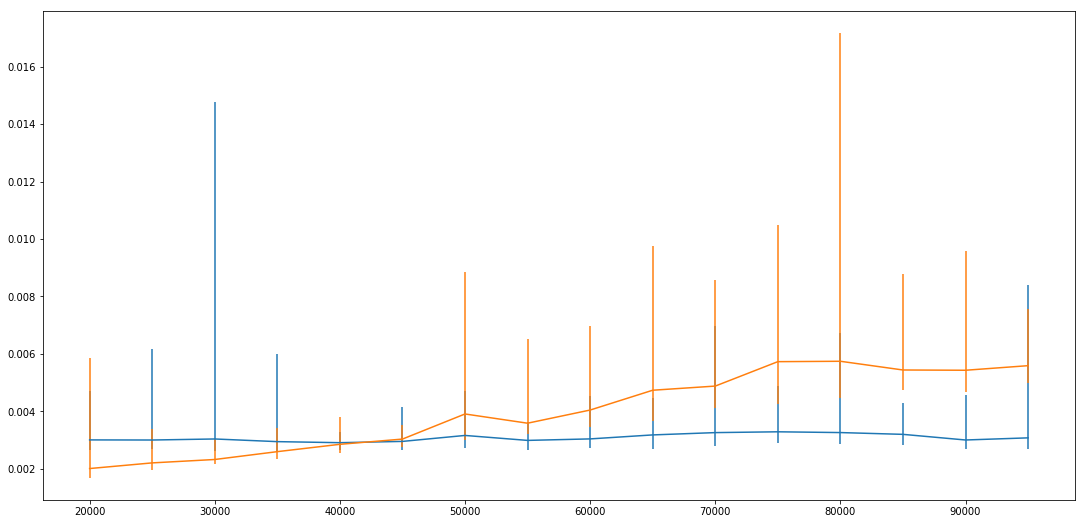

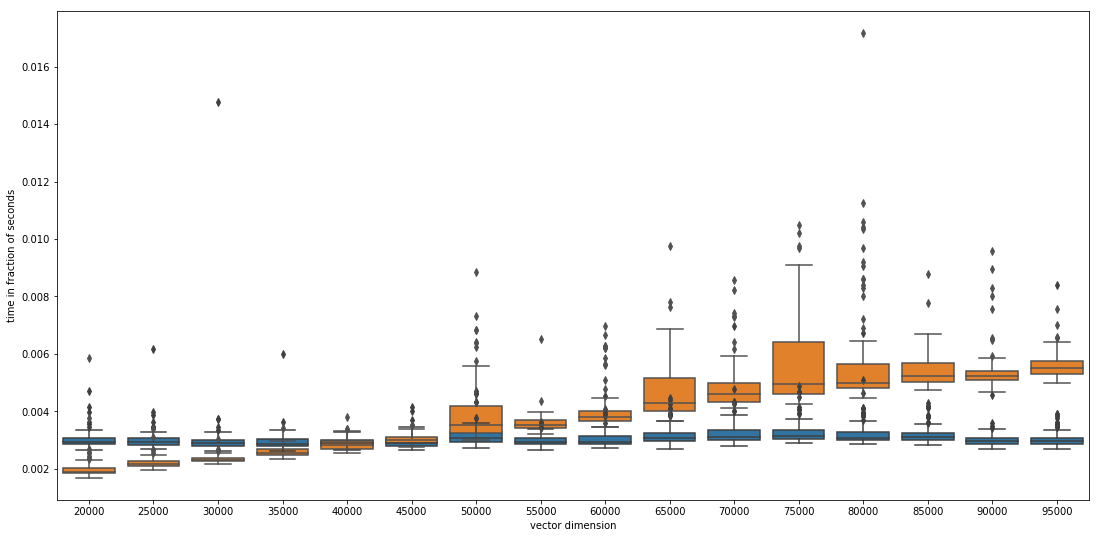

In [18]:
common_params = {}
common_params["generate_vectors"] = "y"
common_params["vectors_per_bag"] = "50"
common_params["numpy_vectors"] = "y"
mx_params = {}
mx_params["numpy_vectors"] = "y"
tf_params = {}

df_vector_creation_vary_dimension_numpy = run_experiment_dimensions(mx_vector_creation, tf_vector_creation,
                                        start_dim= 20000, bigger_dim=100000, step_size=5000,
                                        nr_tries=20, tries_per_seed=5, 
                                        common=common_params, mx_only=mx_params, tf_only=tf_params, 
                                        verbose = False)

print("Numpy")
plot_time_vs_dimension_line_errorbar(df_vector_creation_vary_dimension_numpy)
plot_time_vs_dimension_boxplot(df_vector_creation_vary_dimension_numpy)

# List of float as input

Python List


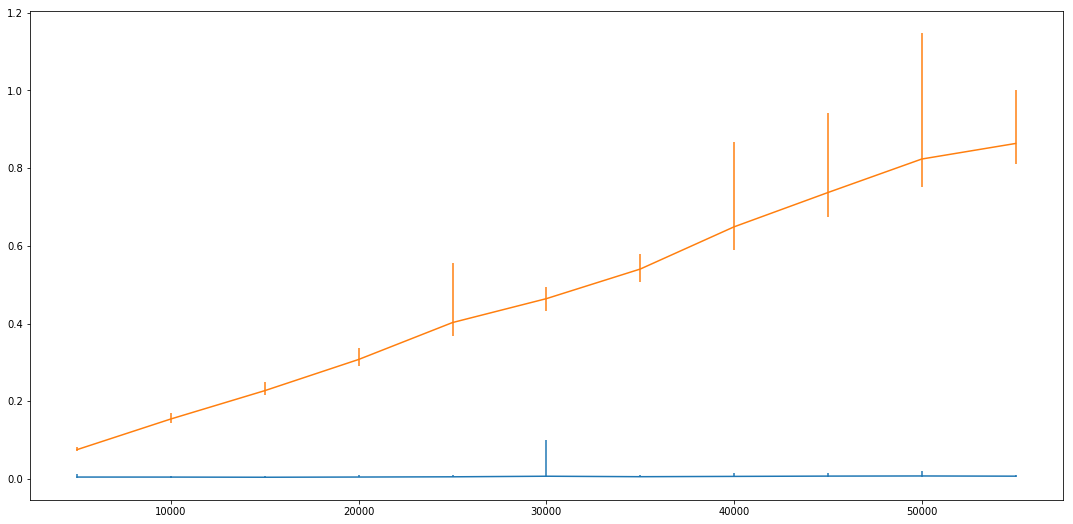

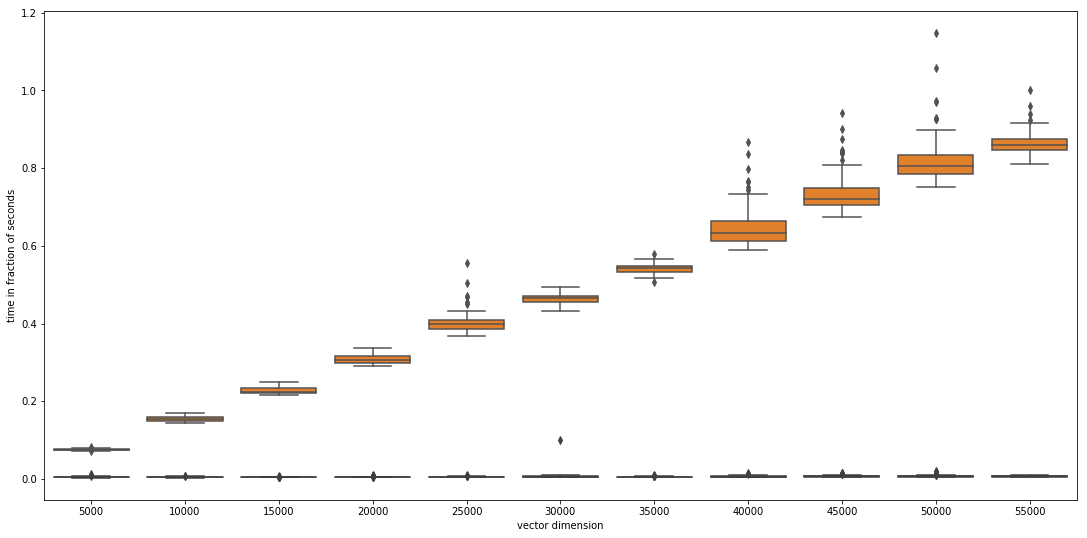

In [19]:
common_params = {}
common_params["generate_vectors"] = "y"
common_params["vectors_per_bag"] = "50"
common_params["numpy_vectors"] = "n"
mx_params = {}
mx_params["numpy_vectors"] = "n"
tf_params = {}

df_vector_creation_vary_dimension_python_list = run_experiment_dimensions(mx_vector_creation, tf_vector_creation,
                                        start_dim= 5000, bigger_dim=60000, step_size=5000,
                                        nr_tries=20, tries_per_seed=5, 
                                        common=common_params, mx_only=mx_params, tf_only=tf_params, 
                                        verbose = False)

print("Python List")
plot_time_vs_dimension_line_errorbar(df_vector_creation_vary_dimension_python_list)
plot_time_vs_dimension_boxplot(df_vector_creation_vary_dimension_python_list)

# 3. Activation Function
Task to Benchmark: Apply the activation functions to a sequence of vectors of a fixed dimensions

Common to both frameworks: the same vectors (created in numpy) are used and the activation functions present in both frameworks are used

In [41]:
# define the two benchmarking functions
def mx_apply_activation(params_dict, params_mx = None):
    bag_of_vectors = params_mx["pre_made_vectors"]
    act_name = params_dict["activation"]
    mx_vectors_after_activation : List[mx.ndarray] = []
    for input_vector in bag_of_vectors:
        mx_vectors_after_activation += [mx.ndarray.Activation(input_vector, act_type = act_name)]
    return mx_vectors_after_activation


def tf_apply_activation(params_dict, params_tf = None):
    bag_of_vectors = params_tf["pre_made_vectors"]
    act_name = params_dict["activation"]
    tf_vectors_after_activation : List[tf.Tensor] = []
    for input_vector in bag_of_vectors:
        if act_name == "sigmoid":
            tf_vectors_after_activation += [tf.keras.activations.sigmoid(input_vector)]
        if act_name == "relu":
            tf_vectors_after_activation += [tf.keras.activations.relu(input_vector)]
        if act_name == "softsign":
            tf_vectors_after_activation += [tf.keras.activations.softsign(input_vector)]
        if act_name == "tanh":
            tf_vectors_after_activation += [tf.keras.activations.tanh(input_vector)]
        if act_name == "softrelu":
            tf_vectors_after_activation += [tf.keras.activations.softplus(input_vector)]
    return tf_vectors_after_activation

Sigmoid


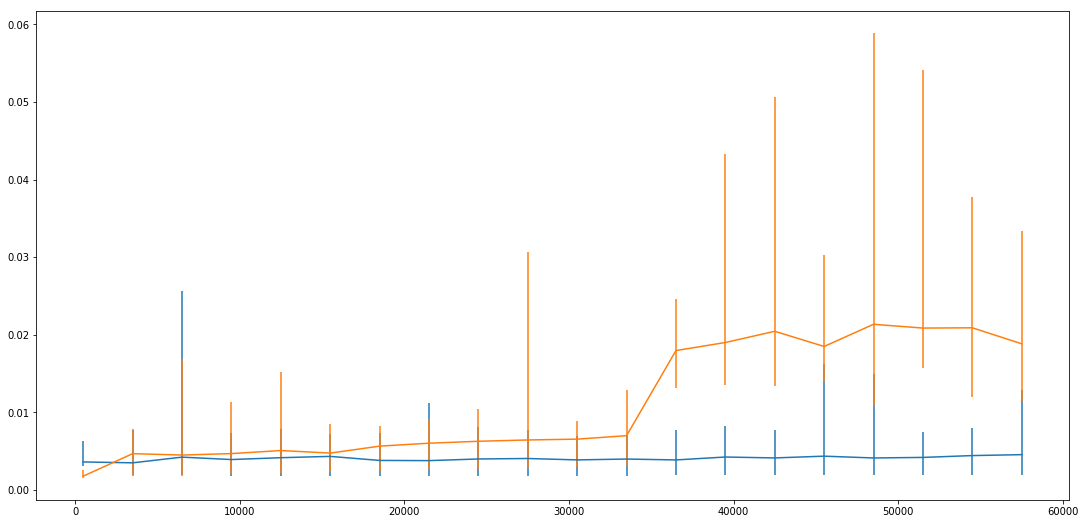

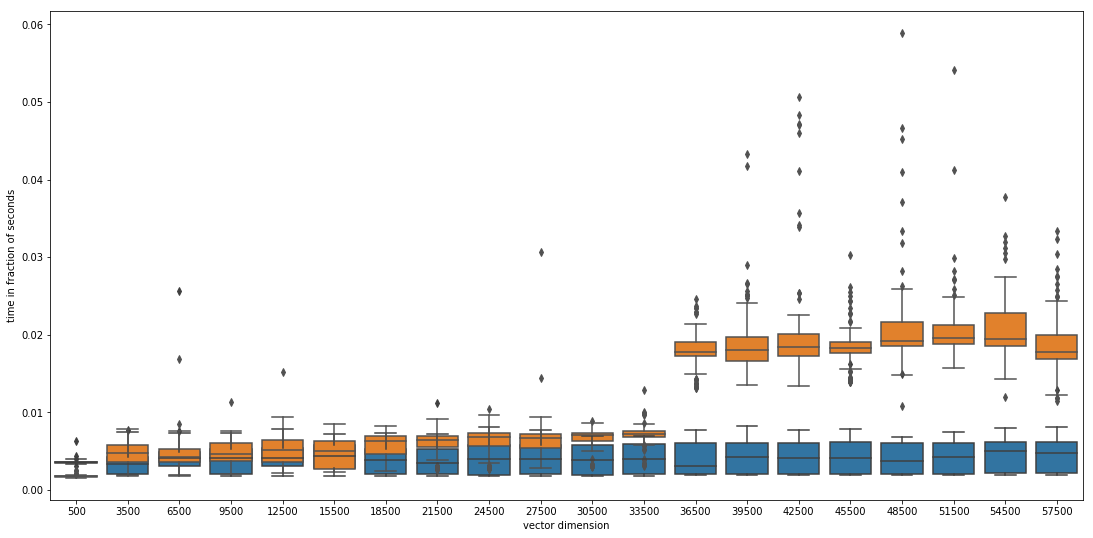

In [42]:

common_params = {}
common_params["generate_vectors"] = "y"
common_params["vectors_per_bag"] = "50"
common_params["numpy_vectors"] = "y"
common_params["need_of_premade_vectors"] = "y"
mx_params = {}
mx_params["numpy_vectors"] = "y"
tf_params = {}

common_params["activation"] = "sigmoid"
df_act_sigmoid_vary_dimension = run_experiment_dimensions(mx_apply_activation, tf_apply_activation,
                                        start_dim= 500, bigger_dim=60000, step_size=3000,
                                        nr_tries=20, tries_per_seed=5, 
                                        common=common_params, mx_only=mx_params, tf_only=tf_params, 
                                        verbose = False)

print("Sigmoid")
plot_time_vs_dimension_line_errorbar(df_act_sigmoid_vary_dimension)
plot_time_vs_dimension_boxplot(df_act_sigmoid_vary_dimension)

relu


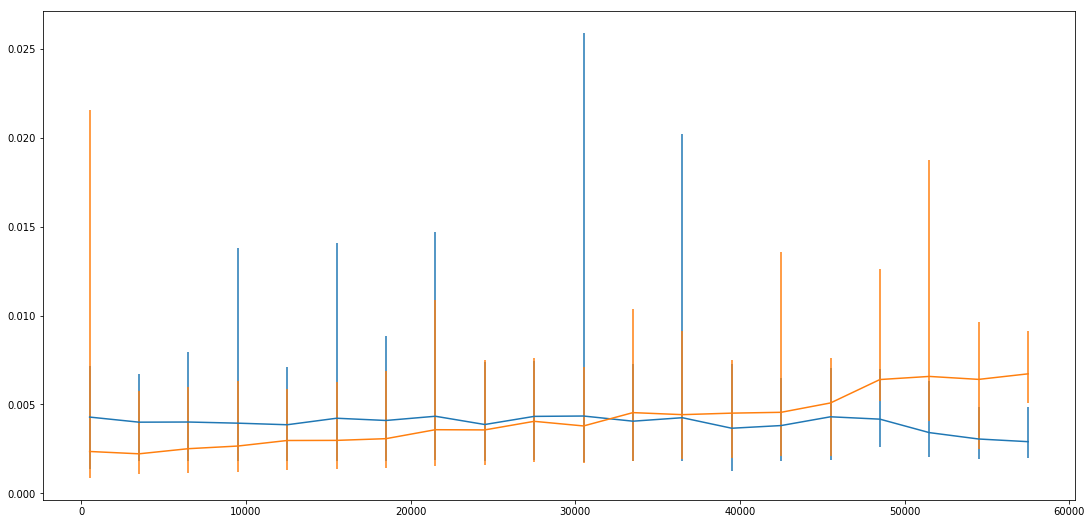

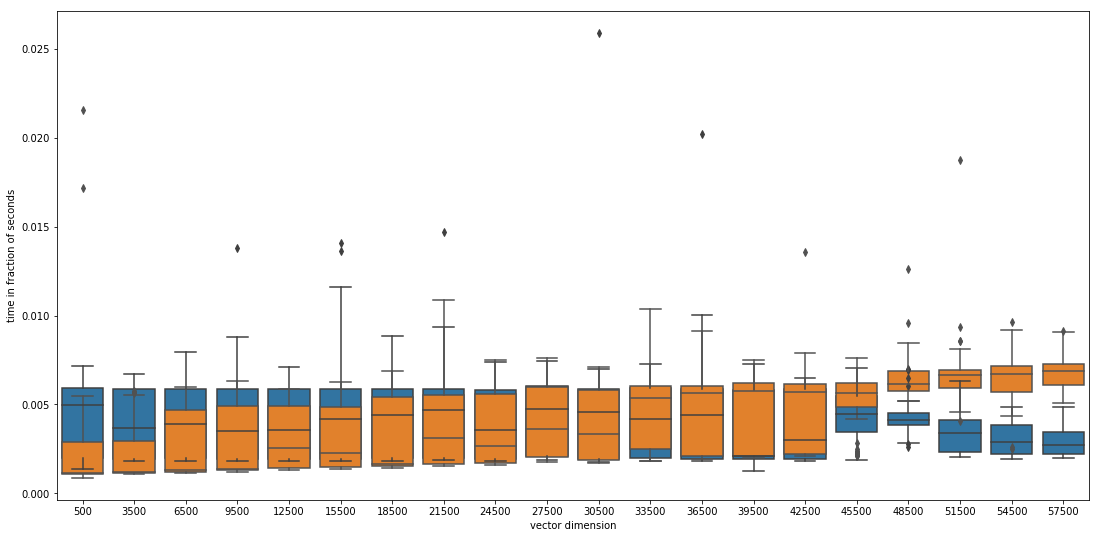

In [43]:
common_params = {}
common_params["generate_vectors"] = "y"
common_params["vectors_per_bag"] = "50"
common_params["numpy_vectors"] = "y"
common_params["need_of_premade_vectors"] = "y"
mx_params = {}
mx_params["numpy_vectors"] = "y"
tf_params = {}

common_params["activation"] = "relu"
df_act_relu_vary_dimension = run_experiment_dimensions(mx_apply_activation, tf_apply_activation,
                                        start_dim= 500, bigger_dim=60000, step_size=3000,
                                        nr_tries=20, tries_per_seed=5, 
                                        common=common_params, mx_only=mx_params, tf_only=tf_params, 
                                        verbose = False)

print("relu")
plot_time_vs_dimension_line_errorbar(df_act_relu_vary_dimension)
plot_time_vs_dimension_boxplot(df_act_relu_vary_dimension)

Softrelu


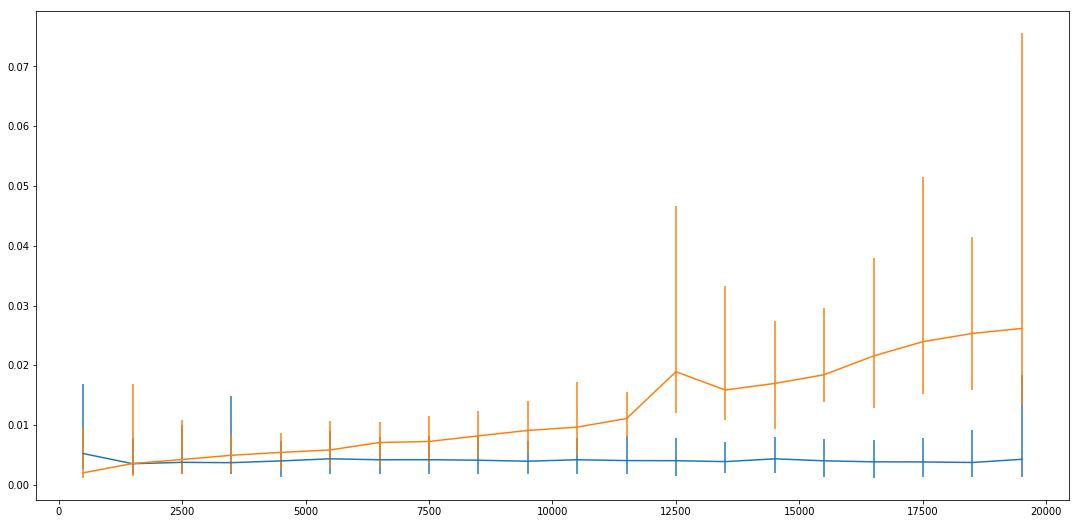

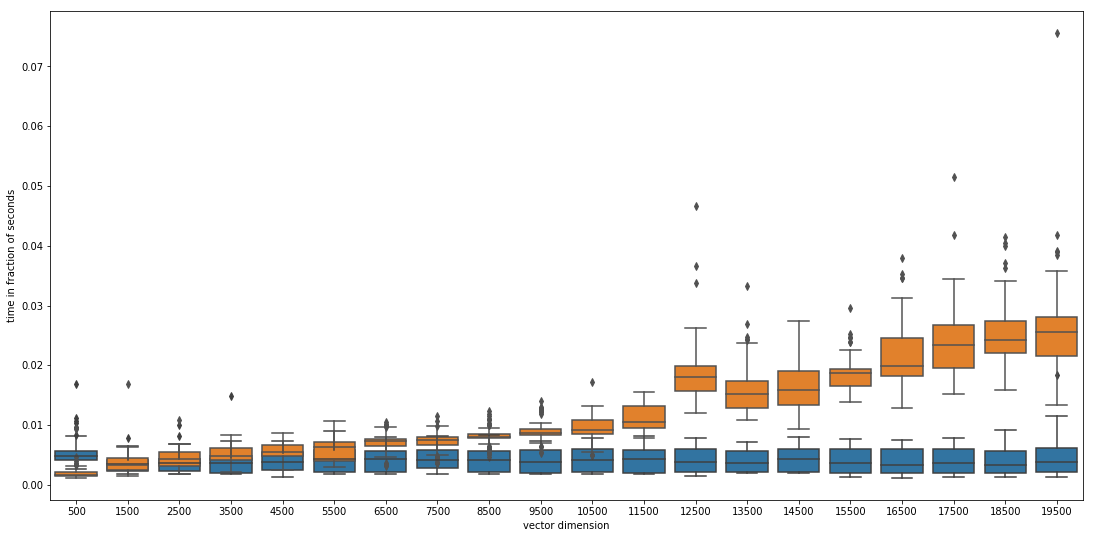

In [46]:
common_params = {}
common_params["generate_vectors"] = "y"
common_params["vector_dim"] = "100"
common_params["vectors_per_bag"] = "50"
common_params["numpy_vectors"] = "y"
common_params["need_of_premade_vectors"] = "y"
mx_params = {}
mx_params["numpy_vectors"] = "y"
tf_params = {}

common_params["activation"] = "softrelu"
df_act_softrelu_vary_dimension = run_experiment_dimensions(mx_apply_activation, tf_apply_activation,
                                        start_dim= 500, bigger_dim=20000, step_size=1000,
                                        nr_tries=20, tries_per_seed=5, 
                                        common=common_params, mx_only=mx_params, tf_only=tf_params, 
                                        verbose = False)

print("Softrelu")
plot_time_vs_dimension_line_errorbar(df_act_softrelu_vary_dimension)
plot_time_vs_dimension_boxplot(df_act_softrelu_vary_dimension)

tanh


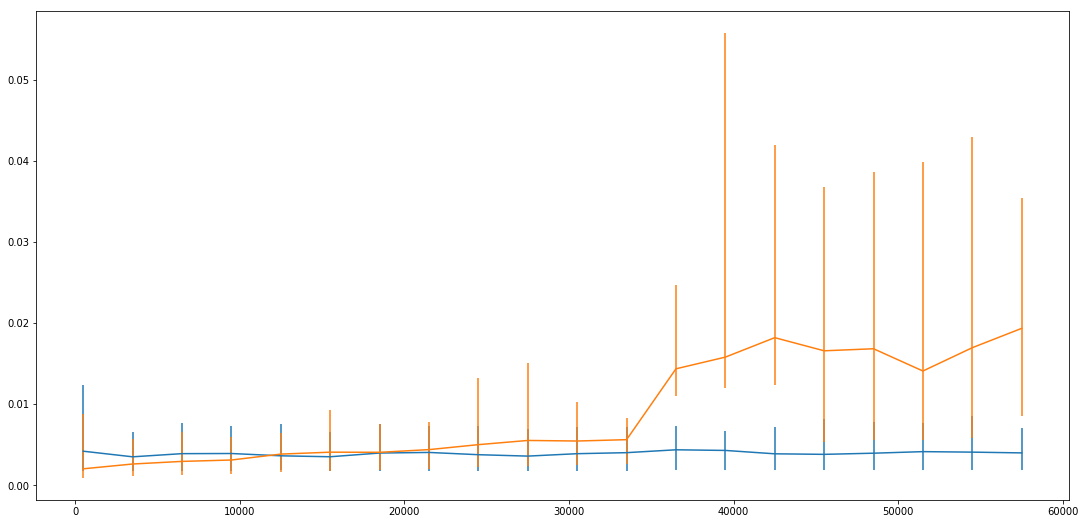

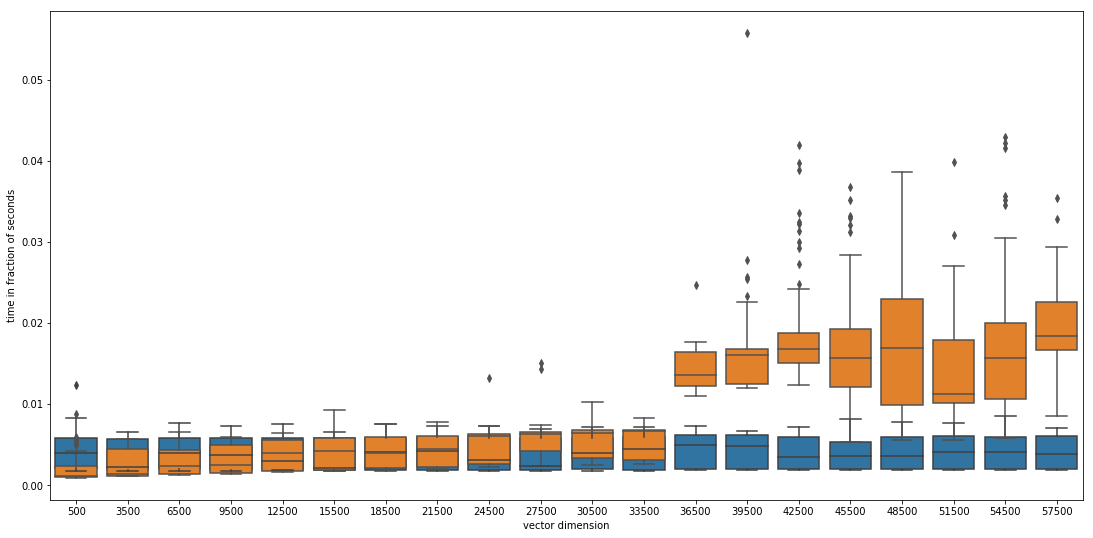

In [48]:
common_params = {}
common_params["generate_vectors"] = "y"
common_params["vector_dim"] = "100"
common_params["vectors_per_bag"] = "50"
common_params["numpy_vectors"] = "y"
common_params["need_of_premade_vectors"] = "y"
mx_params = {}
mx_params["numpy_vectors"] = "y"
tf_params = {}

common_params["activation"] = "tanh"
df_act_tanh_vary_dimension = run_experiment_dimensions(mx_apply_activation, tf_apply_activation,
                                        start_dim= 500, bigger_dim=60000, step_size=3000,
                                        nr_tries=20, tries_per_seed=5, 
                                        common=common_params, mx_only=mx_params, tf_only=tf_params, 
                                        verbose = False)

print("tanh")
plot_time_vs_dimension_line_errorbar(df_act_tanh_vary_dimension)
plot_time_vs_dimension_boxplot(df_act_tanh_vary_dimension)

softsign


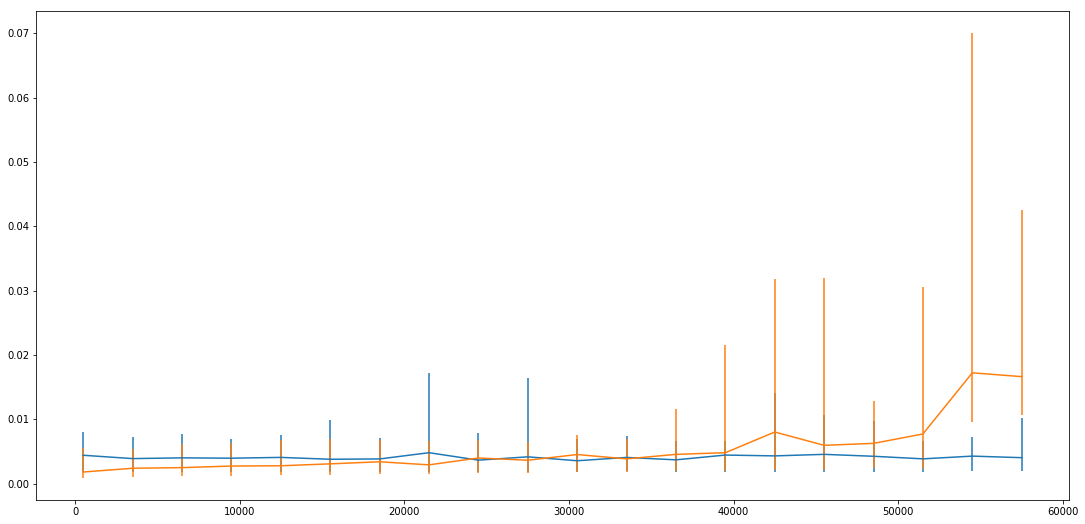

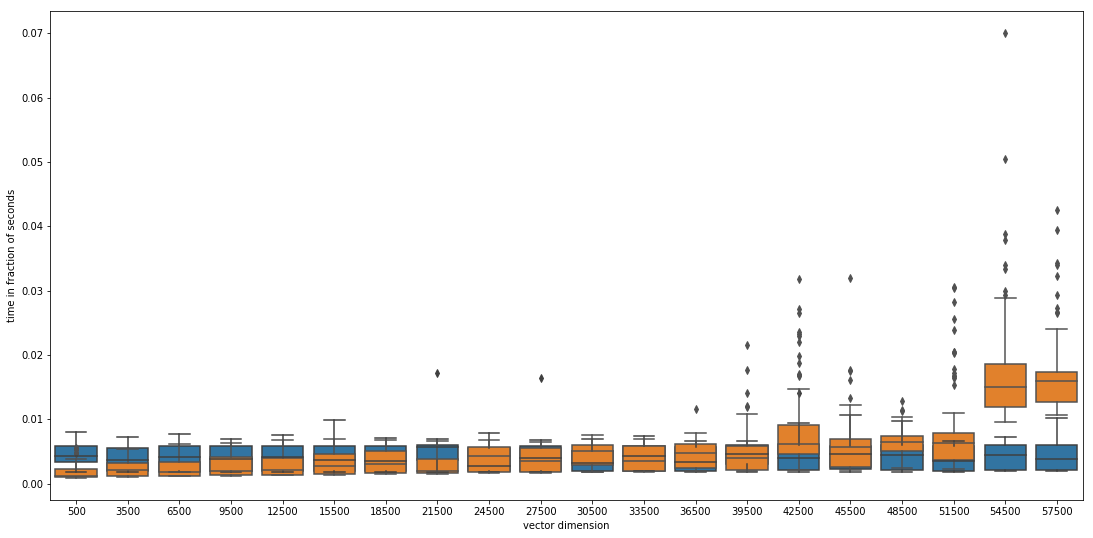

In [49]:
common_params = {}
common_params["generate_vectors"] = "y"
common_params["vector_dim"] = "100"
common_params["vectors_per_bag"] = "50"
common_params["numpy_vectors"] = "y"
common_params["need_of_premade_vectors"] = "y"
mx_params = {}
mx_params["numpy_vectors"] = "y"
tf_params = {}

common_params["activation"] = "softsign"
df_act_softsign_vary_dimension = run_experiment_dimensions(mx_apply_activation, tf_apply_activation,
                                        start_dim= 500, bigger_dim=60000, step_size=3000,
                                        nr_tries=20, tries_per_seed=5, 
                                        common=common_params, mx_only=mx_params, tf_only=tf_params, 
                                        verbose = False)

print("softsign")
plot_time_vs_dimension_line_errorbar(df_act_softsign_vary_dimension)
plot_time_vs_dimension_boxplot(df_act_softsign_vary_dimension)

In [ ]:

LIST_ACTIVATION = ["sigmoid", "relu", "softrelu", "tanh", "softsign"]

# CREATE PLOTS
NR_ROWS = 2 
NR_COLS = 3
fig, axs = plt.subplots(NR_ROWS, NR_COLS)#, sharex=True, sharey=True)
fig.set_size_inches(18.5, 10.5)

for i, activation in enumerate(LIST_ACTIVATION):
    print("Starting computing ", activation, "...")
    # find the proper column and row to place this subplot
    row = int(i / NR_COLS)
    col = i % NR_COLS
    # reset timing
    mx_timing_activation = []
    tf_timing_activation = []
    for seed in range(NR_TRIES):
        #print(seed, end="-")
        # generate vectors in list of float
        bag_of_vectors : List[np.ndarray] = generate_Vectors(seed, DIMENSIONS, NR_VECTORS_PER_TRY, numpy = True)
        mx_bag_of_vectors = mx_vector_creation(bag_of_vectors, numpy= True)
        tf_bag_of_vectors = tf_vector_creation(bag_of_vectors)
        # mxnet
        start_mx = time.process_time()
        mx_vectors = mx_apply_activation(mx_bag_of_vectors, act_name = activation)
        end_mx = time.process_time()
        elapsed_mx = end_mx - start_mx
        mx_timing_activation += [elapsed_mx]
        # tensorflow
        start_tf = time.process_time()
        tf_vectors = tf_apply_activation(tf_bag_of_vectors, act_name = activation)
        end_tf = time.process_time()
        elapsed_tf = end_tf - start_tf
        tf_timing_activation += [elapsed_tf]
    line_mxnet = axs[row, col].plot(mx_timing_activation, color="C0") # blue
    line_tensorflow = axs[row, col].plot(tf_timing_activation, color="C1") #orange
    axs[row, col].set_title(activation)

#test_independence(mx_timing_activation, tf_timing_activation) 
#print("\nTESTING ACTIVATION FUNCTION: " + ACTIVATION_TO_TEST)
#plot_timing(mx_timing_activation, tf_timing_activation)
print("MXnet : blue line - Tensorflow : orange line")
plt.show()

# 4. Dot Product
Task to Benchmark: Do the dot product between a lot of vectors randomly picked from a previously created collection of vectors (same length to allow the dot product). These vectors should be reasonably long (e.g. 10k)

Common to both frameworks: The same random bag of vectors is used. This collection is created in its proprietary library function: tensor and ndarray, before benchmarking. The randomly picked vectors are the same.

In [51]:
# define the two benchmarking functions
def mx_dot_product(params_dict, params_mx = None):
    bag_of_vectors : mx.ndarray = params_mx["pre_made_vectors"]
    list_of_index_pairs : List[Tuple[int, int]] = params_dict["pair_of_indices"]
    # https://mxnet.incubator.apache.org/api/python/docs/api/ndarray/ndarray.html#mxnet.ndarray.dot
    # list_of_index_pairs contains pairs of integers
    # the first integer indicates the index (position) of the 1st vector in the bag_of_vectors
    # the first integer indicates the index (position) of the 2nd vector in the bag_of_vectors
    mx_dot_product_results : List[mx.ndarray] = []
    for (i_first, j_second) in list_of_index_pairs:
        first = bag_of_vectors[i_first][0]
        second = bag_of_vectors[j_second][0]
        mx_dot_product_results += [mx.ndarray.dot(first, second)]
    return mx_dot_product_results


def tf_dot_product(params_dict, params_tf = None):
    bag_of_vectors : tf.Tensor = params_tf["pre_made_vectors"]
    list_of_index_pairs : List[Tuple[int, int]] = params_dict["pair_of_indices"]
    #https://www.tensorflow.org/api_docs/python/tf/tensordot
    tf_dot_product_results : List[tf.Tensor] = []
    for (i_first, j_second) in list_of_index_pairs:
        first = bag_of_vectors[i_first][0]
        second = bag_of_vectors[j_second][0]
        tf_dot_product_results += [tf.tensordot(first, tf.transpose(second), axes=1)]
    return tf_dot_product_results

Dot Product


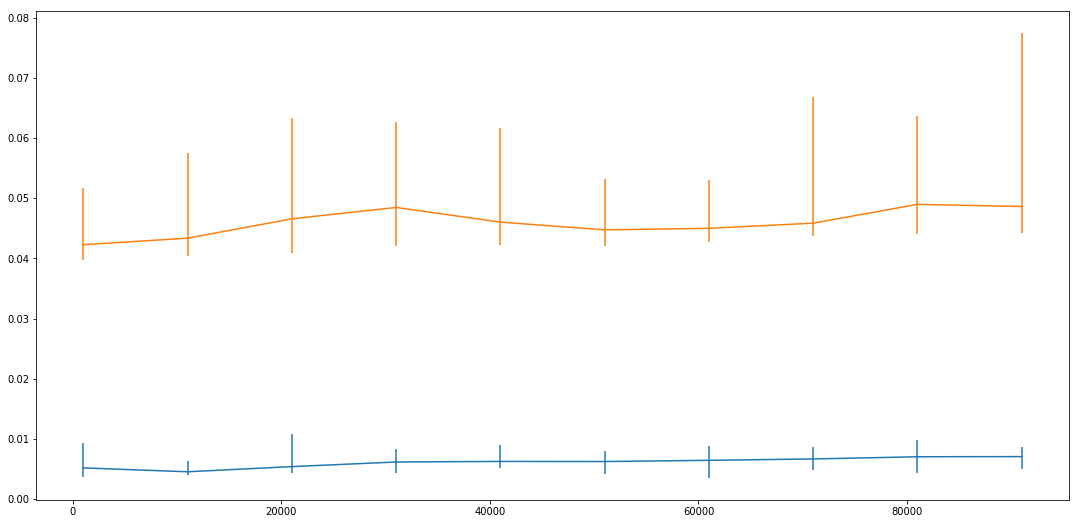

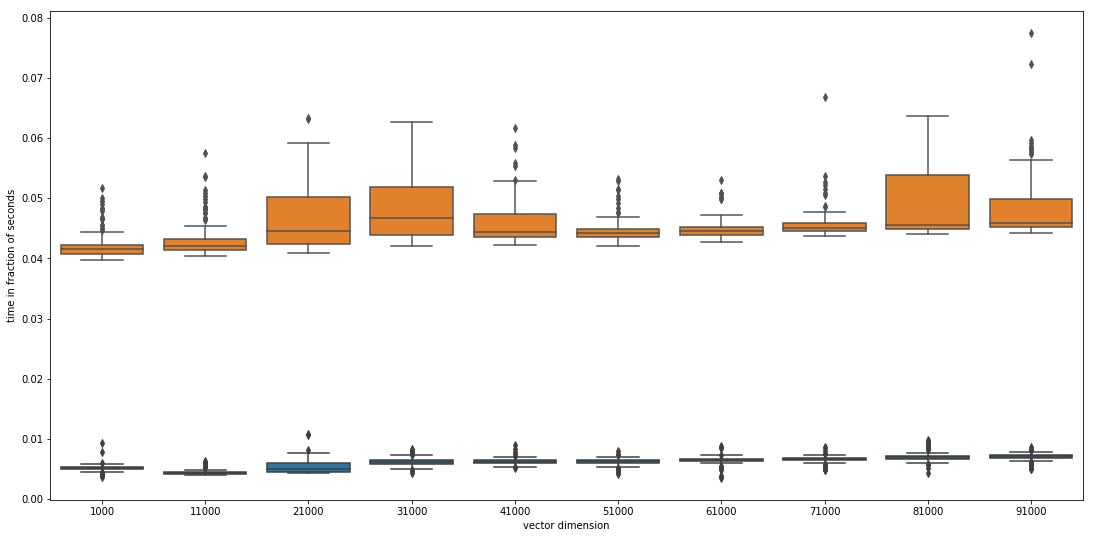

In [52]:
common_params = {}
common_params["generate_vectors"] = "y"
common_params["vectors_per_bag"] = "50"
common_params["numpy_vectors"] = "y"
common_params["need_of_premade_vectors"] = "y"
mx_params = {}
mx_params["numpy_vectors"] = "y"
tf_params = {}

common_params["dot_product_per_trial"] = "50"

df_dot_product_vary_dimension = run_experiment_dimensions(mx_dot_product, tf_dot_product,
                                        start_dim= 1000, bigger_dim=100000, step_size=10000,
                                        nr_tries=20, tries_per_seed=5, 
                                        common=common_params, mx_only=mx_params, tf_only=tf_params, 
                                        verbose = False)

print("Dot Product")
plot_time_vs_dimension_line_errorbar(df_dot_product_vary_dimension)
plot_time_vs_dimension_boxplot(df_dot_product_vary_dimension)

In [ ]:
NR_TRIES = 1
DIMENSIONS = 7
NR_VECTORS_PER_TRY = 50
NR_DOT_PRODUCTS_PER_TRY = 3
# create vectors
bag_of_vectors : List[np.ndarray] = generate_Vectors(seed, DIMENSIONS, NR_VECTORS_PER_TRY, numpy = True)
mx_bag_of_vectors = mx_vector_creation(bag_of_vectors, numpy= True)
tf_bag_of_vectors = tf_vector_creation(bag_of_vectors)
np.random.seed(42)
indices = np.random.randint(len(bag_of_vectors), size= NR_DOT_PRODUCTS_PER_TRY * 2)
pairs = np.split(indices, NR_DOT_PRODUCTS_PER_TRY)
print(pairs)


In [ ]:
mx_dot_product(mx_bag_of_vectors, pairs)[0]

In [ ]:
tf_dot_product(tf_bag_of_vectors, pairs)[0]

**MXNET is more precise**: We can observe that MXnet uses more digit to store the result. 

Result: MX shows better performance. And dot product is a **crucial aspect in neural network**.

# 5. Matrix Multiplication
Task to Benchmark: Multiply a bunch of matrices of different dimensions.

Common to both frameworks: The matrices are randomly generated before the benchmark takes place and they are stored in their proprietary format: tensor and ndarray. The randomness is the same in both frameworks. Random generation is handled by numpy.

In [53]:
# define the two benchmarking functions
def mx_matrix_multiplication(params_dict, params_mx = None):
    #https://mxnet.incubator.apache.org/api/python/docs/api/ndarray/linalg/index.html#mxnet.ndarray.linalg.gemm2
    bag_of_matrices : mx.ndarray = params_mx["pre_made_matrices"]
    list_of_index_pairs : List[Tuple[int, int]] = params_dict["pair_of_indices"]
    # list_of_index_pairs contains pairs of integers
    # the first integer indicates the index (position) of the 1st vector in the bag_of_vectors
    # the first integer indicates the index (position) of the 2nd vector in the bag_of_vectors
    mx_mat_mul_results : List[mx.ndarray] = []
    for (i_first, j_second) in list_of_index_pairs:
        first = bag_of_matrices[i_first]
        second = bag_of_matrices[j_second]
        mx_mat_mul_results += [mx.nd.linalg.gemm2(first, second)]
    #print("mx_mat_mul_results:", mx_mat_mul_results[0])
    return mx_mat_mul_results


def tf_matrix_multiplication(params_dict, params_tf = None):
    bag_of_matrices : tf.Tensor = params_tf["pre_made_matrices"]
    list_of_index_pairs : List[Tuple[int, int]] = params_dict["pair_of_indices"]
    #https://www.tensorflow.org/api_docs/python/tf/tensordot
    tf_mat_mul_results : List[tf.Tensor] = []
    for (i_first, j_second) in list_of_index_pairs:
        first = bag_of_matrices[i_first]
        second = bag_of_matrices[j_second]
        tf_mat_mul_results += [tf.tensordot(first, second, axes = [[1], [0]])]
    #print("tf_mat_mul_results:", tf_mat_mul_results[0])
    return tf_mat_mul_results

In [135]:
np.random.seed(42)
A = np.random.rand(2,2)
B = np.random.rand(2,2)
res_tf = tf.tensordot(A, B, axes = [[1], [0]])
res_mx = mx.nd.linalg.gemm2(mx.ndarray.from_numpy(A), mx.ndarray.from_numpy(B))
print("TF:",res_tf)
print("MX:",res_mx)

TF: tf.Tensor(
[[0.11365616 0.88191226]
 [0.14897695 0.63273074]], shape=(2, 2), dtype=float64)
MX: 
[[0.11365616 0.88191226]
 [0.14897695 0.63273074]]
<NDArray 2x2 @cpu(0)>


Matrix Multiplication


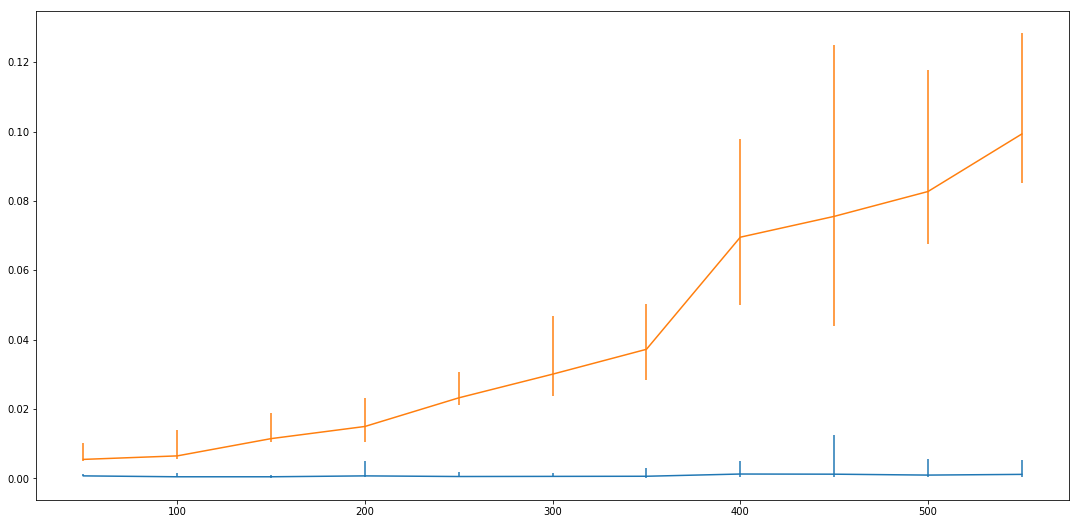

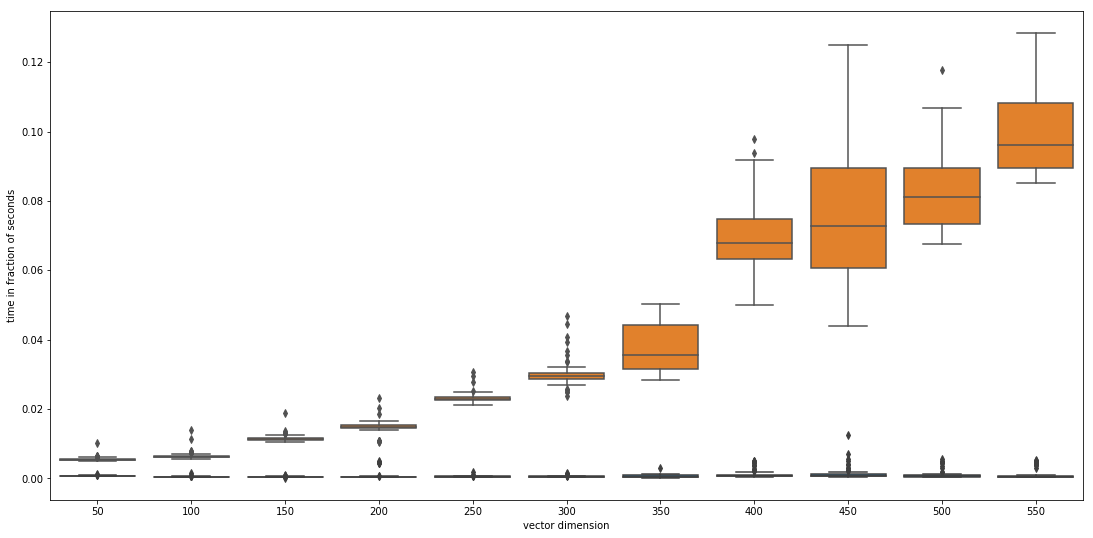

In [54]:
common_params = {}
common_params["matrices_per_bag"] = "50"
common_params["numpy_vectors"] = "y"
common_params["need_of_premade_matrices"] = "y"
mx_params = {}
mx_params["numpy_vectors"] = "y"
tf_params = {}

common_params["mat_mul_per_trial"] = "10"


df_mat_mul_vary_dimension = run_experiment_dimensions(mx_matrix_multiplication, tf_matrix_multiplication,
                                        start_dim= 50, bigger_dim=600, step_size=50,
                                        nr_tries=20, tries_per_seed=5, 
                                        common=common_params, mx_only=mx_params, tf_only=tf_params, 
                                        verbose = False)

print("Matrix Multiplication")
plot_time_vs_dimension_line_errorbar(df_mat_mul_vary_dimension)
plot_time_vs_dimension_boxplot(df_mat_mul_vary_dimension)

# 6. Flatten vector/tensor
Task to Benchmark: Flatten a preconstructed collection (e.g. # elements = 1000)  of multidimensional array.

Common to both frameworks: The two collections are created before the benchmark by using the proprietary functions. The two collections are identical. The chosen array are the same for both frameworks.

In [55]:
# define the two benchmarking functions

def mx_flatten_square_matrix(params_dict, params_mx = None):
    #https://mxnet.apache.org/api/python/docs/api/ndarray/ndarray.html#mxnet.ndarray.Reshape
    bag_of_matrices : mx.ndarray = params_mx["pre_made_matrices"]
    mx_flattened_vectors : List[mx.ndarray] = []
    for matrix in bag_of_matrices:
        mx_flattened_vectors += [matrix.reshape(shape=(-1,))]
    #print("Mxnet:", mx_flattened_vectors[0].shape)
    return mx_flattened_vectors

def tf_flatten_square_matrix(params_dict, params_tf = None):
    #https://www.tensorflow.org/api_docs/python/tf/reshape
    bag_of_matrices : tf.Tensor = params_tf["pre_made_matrices"]
    tf_flattened_vectors : List[tf.Tensor] = []
    for matrix in bag_of_matrices:
        tf_flattened_vectors += [tf.reshape(matrix, [-1])]
    #print("TF:",tf_flattened_vectors[0].shape)
    return tf_flattened_vectors

Flatten Matrices


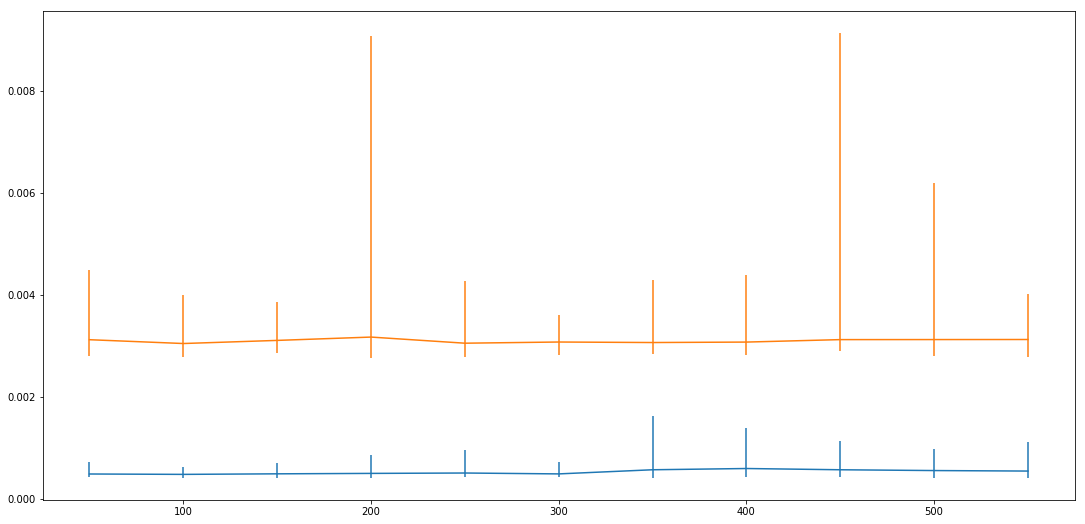

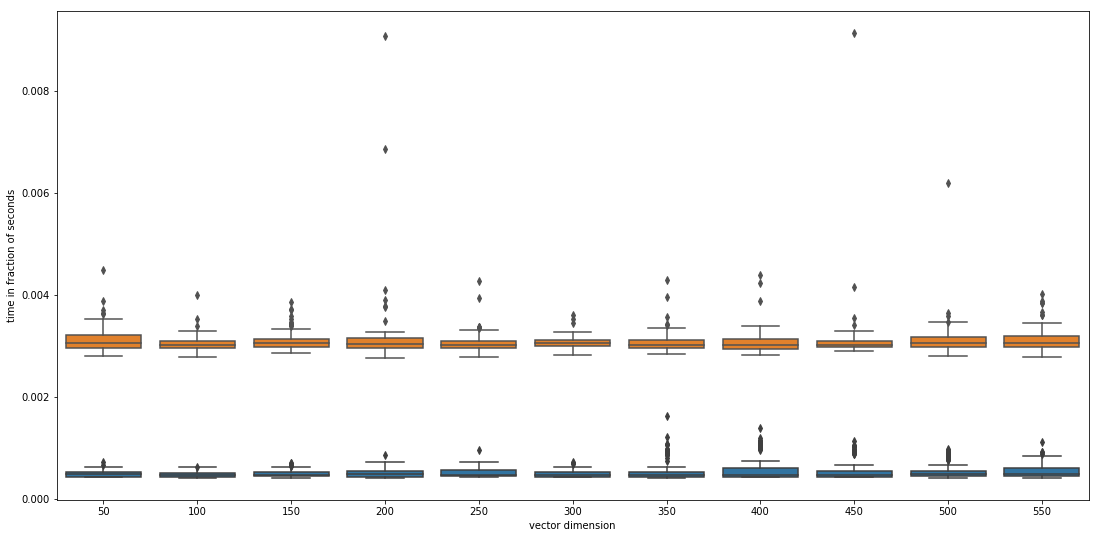

In [58]:
common_params = {}
common_params["matrices_per_bag"] = "50"
common_params["numpy_vectors"] = "y"
common_params["need_of_premade_matrices"] = "y"
mx_params = {}
mx_params["numpy_vectors"] = "y"
tf_params = {}

df_flatten_vary_dimension = run_experiment_dimensions(mx_flatten_square_matrix, tf_flatten_square_matrix,
                                        start_dim= 50, bigger_dim=600, step_size=50,
                                        nr_tries=20, tries_per_seed=5, 
                                        common=common_params, mx_only=mx_params, tf_only=tf_params, 
                                        verbose = False)

print("Flatten Matrices")
plot_time_vs_dimension_line_errorbar(df_flatten_vary_dimension)
plot_time_vs_dimension_boxplot(df_flatten_vary_dimension)

# 7. Normalize vector/tensor
Task to Benchmark: Normalize a preconstructed collection (e.g. # elements = 1000) of multidimensional array.

Common to both frameworks: The two collections are created before the benchmark by using the proprietary functions. The two collections are identical. The chosen array are the same for both frameworks.

In [59]:
# define the two benchmarking functions

def mx_normalize_square_matrix(params_dict, params_mx = None):
    #https://mxnet.apache.org/api/python/docs/api/ndarray/ndarray.html#mxnet.ndarray.L2Normalization
    bag_of_matrices : mx.ndarray = params_mx["pre_made_matrices"]
    mx_norm_matrices : List[mx.ndarray] = []
    for matrix in bag_of_matrices:
        new_m = matrix/mx.nd.norm(matrix, ord=2, axis=None)
        #print("mx_new_m: ", new_m.shape)
        mx_norm_matrices += [new_m]
    #print("Mxnet:", mx_norm_matrices[0])
    return mx_norm_matrices

def tf_normalize_square_matrix(params_dict, params_tf = None):
    #https://www.tensorflow.org/api_docs/python/tf/linalg/normalize
    bag_of_matrices : tf.Tensor = params_tf["pre_made_matrices"]
    tf_norm_matrices : List[tf.Tensor] = []
    for matrix in bag_of_matrices:
        new_m = tf.linalg.normalize(matrix, ord=2, axis=None)[0]
        #print("tf_new_m: ", new_m.shape)
        tf_norm_matrices+= [new_m]
    #print("TF:",tf_norm_matrices[0])
    return tf_norm_matrices

Normazize Matrices


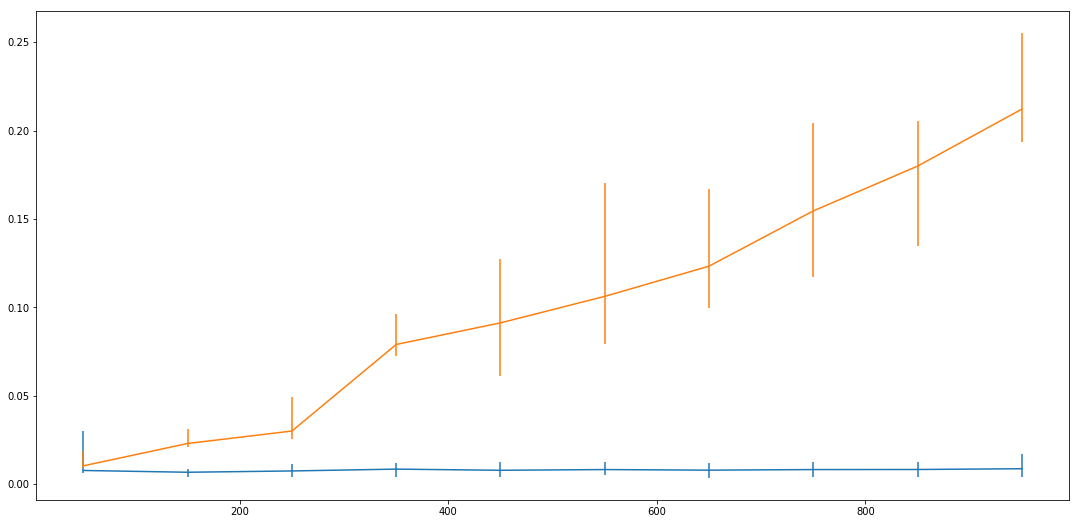

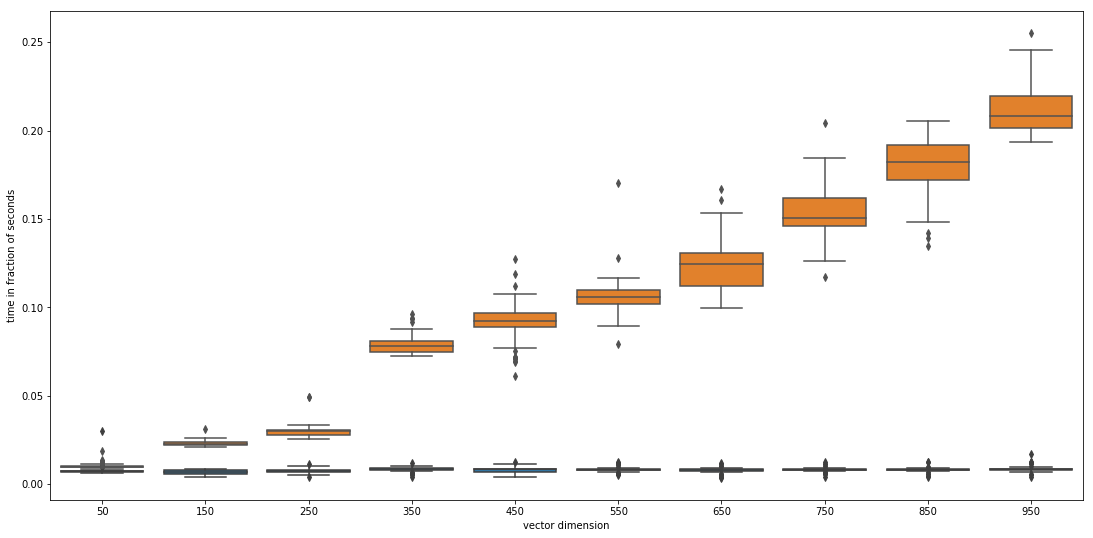

In [60]:
common_params = {}
common_params["matrices_per_bag"] = "50"
common_params["numpy_vectors"] = "y"
common_params["need_of_premade_matrices"] = "y"
mx_params = {}
mx_params["numpy_vectors"] = "y"
tf_params = {}

df_normalize_vary_dimension = run_experiment_dimensions(mx_normalize_square_matrix, tf_normalize_square_matrix,
                                        start_dim= 50, bigger_dim=1000, step_size=100,
                                        nr_tries=20, tries_per_seed=3, 
                                        common=common_params, mx_only=mx_params, tf_only=tf_params, 
                                        verbose = False)

print("Normazize Matrices")
plot_time_vs_dimension_line_errorbar(df_normalize_vary_dimension)
plot_time_vs_dimension_boxplot(df_normalize_vary_dimension)